In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

# Preprocessing

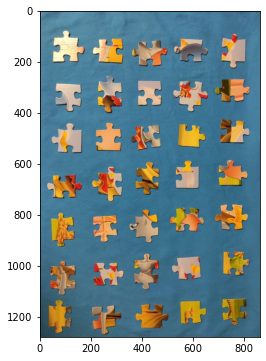

In [199]:
img = cv2.imread('dambo_blue_straight.jpg')
img = img[..., ::-1]
plt.figure(figsize = (8, 6))
plt.imshow(img)
img = cv2.GaussianBlur(img, (11, 11), 0)

## Remove background

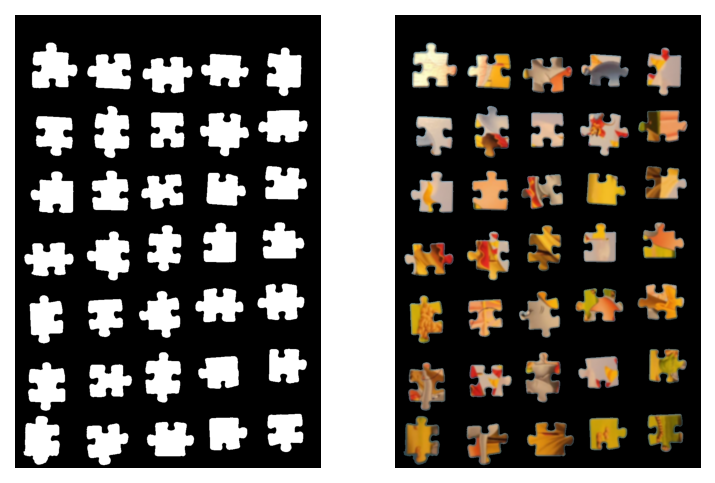

In [200]:
HLS = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

background = np.median(HLS, axis=(0,1))
mask = np.mean(np.abs(HLS-background), axis=-1) < 22
img2 = img.copy()
img2[mask] = 0

plt.figure(dpi=150)
plt.subplot(1,2,1)   
plt.axis('off')
plt.imshow(1 - mask, cmap="gray")
plt.subplot(1,2,2)  
plt.axis('off')
plt.imshow(img2);

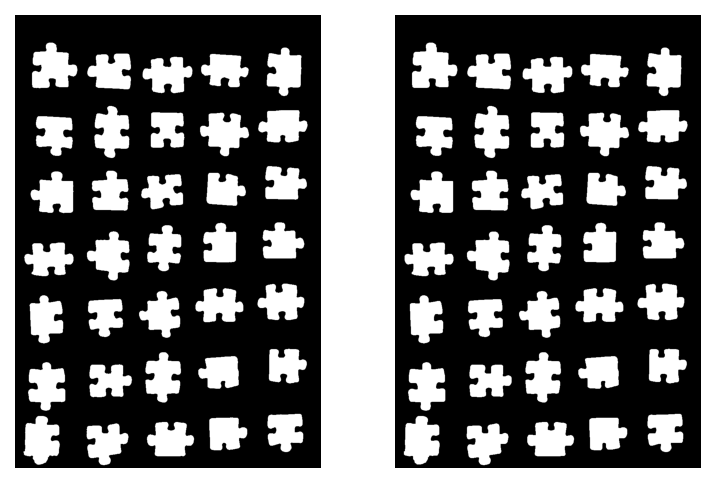

In [201]:
mask_int = mask.astype(np.uint8)
kernel = np.ones((5,5))
mask_int = cv2.morphologyEx(mask_int, cv2.MORPH_CLOSE, kernel)
kernel = np.ones((5,5))
mask_int = cv2.morphologyEx(mask_int, cv2.MORPH_OPEN, kernel)
img2 = img.copy()
img2[mask_int == 1] = 0


plt.figure(dpi=150)
plt.subplot(1,2,1)   
plt.axis('off')
plt.imshow(1 - mask, cmap="gray")
plt.subplot(1,2,2)  
plt.axis('off')
plt.imshow(1 - mask_int, cmap="gray");

## Drawing contours

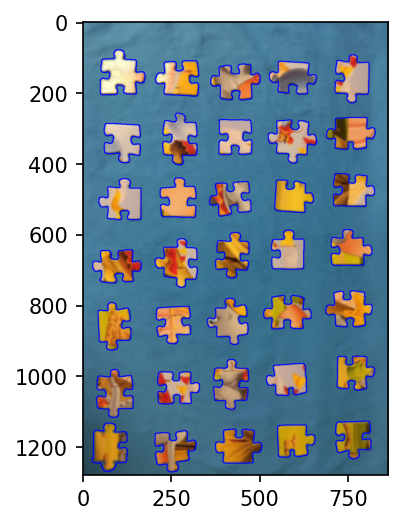

In [202]:
contours, hierarchy = cv2.findContours(1-mask_int, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
areas = []
for i in range(len(contours)):
    areas.append(cv2.contourArea(contours[i]))
cont_to_del = []            
for i in range(len(contours)):
    if areas[i] < 0.5 * max(areas):
        cont_to_del.append(i)
#     else:
#         cv2.drawContours(black, [contours[i]], 0, (255,255,255), 10)
contours = [contours[i] for i in range(len(contours)) if i not in cont_to_del]
        
img_cnt = img.copy()
cv2.drawContours(img_cnt, contours, -1, (0,0,255), 2)
plt.figure(dpi=150)
plt.imshow(img_cnt);

Посмотрим как фон будет отделяться на наших фотках

# Edge detection

Let's extract puzzle pieces from the picture first.

In [486]:
def create_box(im, cnt):
    mins = np.min(cnt, axis=0)[0]
    maxs = np.max(cnt, axis=0)[0]
    top = max(maxs[1]+5 - (mins[1]-5), maxs[0]+5 - (mins[0]-5))
    tmp = im[max(0,int((mins[1] + maxs[1])/2 - top/2)) : int((mins[1] + maxs[1])/2 + top/2), max(0,int((mins[0] + maxs[0])/2 - top/2)) : int((mins[0] + maxs[0])/2 + top/2)]
    return tmp

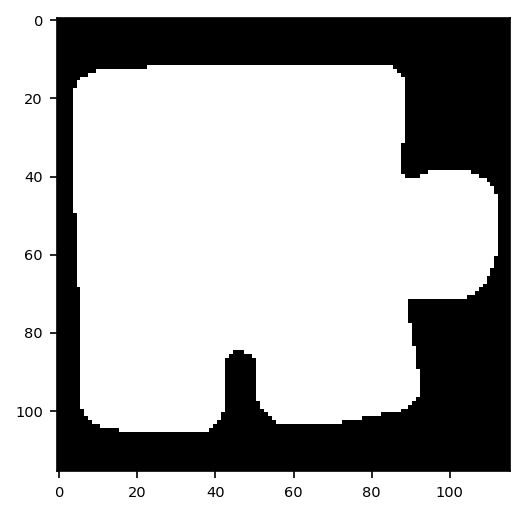

In [488]:
black = np.zeros_like(img)
cv2.drawContours(black, [contours[2]], 0, (255,255,255), 2)
cv2.fillPoly(black, pts =[contours[2]], color=(255,255,255))
black = create_box(black, contours[2])
plt.figure(dpi=150)
plt.imshow(black, cmap='gray');

In [489]:
gray = cv2.cvtColor(black,cv2.COLOR_BGR2GRAY)

dst = cv2.cornerHarris(gray,10,5,0.04)
dst = cv2.dilate(dst,None)


mask = dst>0.15*dst.max()
points = []
for i in range(mask.shape[0]):
    for j in range(mask.shape[1]):
        if mask[i][j]:
            points.append([i,j])

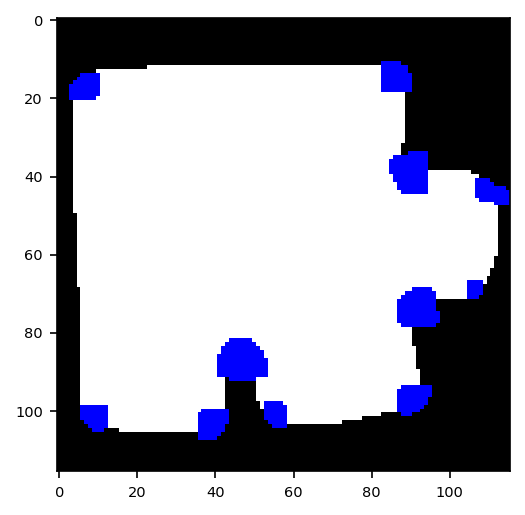

In [490]:
blackk = black.copy()
blackk[mask]=[0,0,255]
plt.figure(dpi=150)
plt.imshow(blackk, cmap='gray');

Non maximum supression

In [491]:
filtered_points = []
tmp = points.copy()
while len(tmp) > 0:
    filtered_points.append(tmp[0])
    target = tmp[0]
    tmp.pop(0)
    kick_list = []
    for j, point in enumerate(tmp):
        dist = np.linalg.norm(np.array(target) - np.array(point))
        if dist < 20:
            kick_list.append(point)
    for ind in kick_list:
        tmp.remove(ind)

In [492]:
filtered_points

[[11, 83],
 [14, 6],
 [34, 90],
 [41, 109],
 [67, 105],
 [76, 87],
 [82, 44],
 [95, 94],
 [98, 56],
 [99, 6],
 [101, 36]]

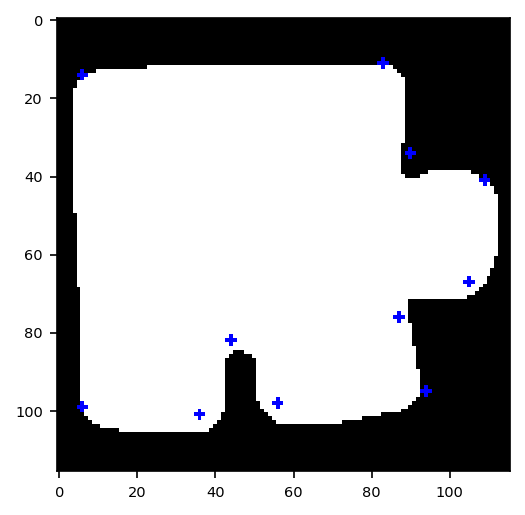

In [493]:
blackk = black.copy()
for point in filtered_points:
    blackk[point[0]][point[1]]=[0,0,255]
    blackk[point[0]-1][point[1]]=[0,0,255]
    blackk[point[0]][point[1]-1]=[0,0,255]
    blackk[point[0]+1][point[1]]=[0,0,255]
    blackk[point[0]][point[1]+1]=[0,0,255]
plt.figure(dpi=150)
plt.imshow(blackk, cmap='gray');

In [497]:
import itertools
from scipy.stats import norm
fours = list(itertools.combinations(filtered_points, 4))

In [498]:
def order_points_2(pts):
    #pts is list !!
    pts[2], pts[3] = pts[3], pts[2]
    return pts

In [499]:
def order_points(pts):  # This function transforms 4 points of rectangle to the the same points in order
    # top-left, top-right, bottom-right, and bottom-left
    rect = np.zeros((4, 2), dtype="float32")
    pts = np.array(sorted(pts, key=lambda x: x[0]))
    top = pts[:2]
    btm = pts[2:]
    if top[0][1] > top[1][1]:
        tl, tr = top[1], top[0]
    else: 
        tl, tr = top[0], top[1]
        
    if btm[0][1] > btm[1][1]:
        bl, br = btm[1], btm[0]
    else:
        bl, br = btm[0], btm[1]

    return np.array([tl, tr, bl, br])

In [500]:
def compute_angles(dots):

    angles = np.zeros((4, 4))

    for i in range(4):
        for j in range(i + 1, 4):

            point_i, point_j = dots[i], dots[j]
            if point_i[0] == point_j[0]:
                angle = 90
            else:
                angle = np.arctan2(point_j[1] - point_i[1], point_j[0] - point_i[0]) * 180 / np.pi

            angles[i, j] = angle
            angles[j, i] = angle

    return angles

In [501]:
def find_rect_scores_2(dots):
    dots = list(dots)
    dots = order_points_2(dots)
    dots = np.array(dots)
    area = cv2.contourArea(dots)
    mse = 0
    da = []
    angles = compute_angles(dots)
    for i1, i2, i3 in [(0, 1, 2), (1, 2, 3), (2, 3, 0), (3, 0, 1)]:
        diff_angle = abs(angles[i1, i2] - angles[i2, i3])
        da.append(abs(diff_angle))
        mse += (diff_angle - 90) ** 2
    return [area, mse, np.mean(da)]

In [504]:
scores = [find_rect_scores_2(four) for j, four in enumerate(fours)]

In [505]:
scores_final = np.array(scores).T
scores_final = scores_final[0]*norm(0, 150).pdf(scores_final[1])

In [506]:
corner_points = list(fours[np.argmax(scores_final)])
corner_points = np.array(order_points_2(corner_points))

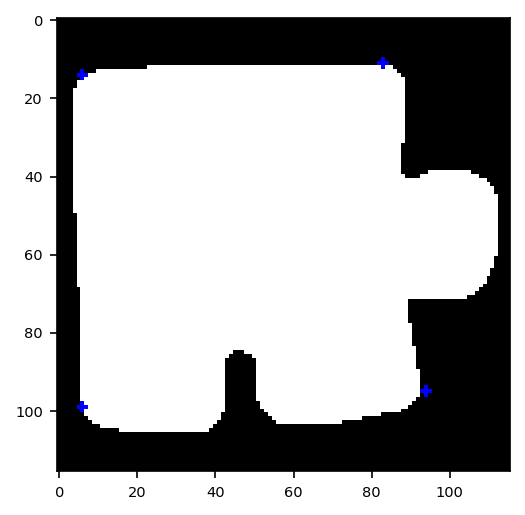

In [507]:
blackk = black.copy()
for point in corner_points:
    blackk[point[0]][point[1]]=[0,0,255]
    blackk[point[0]-1][point[1]]=[0,0,255]
    blackk[point[0]][point[1]-1]=[0,0,255]
    blackk[point[0]+1][point[1]]=[0,0,255]
    blackk[point[0]][point[1]+1]=[0,0,255]
plt.figure(dpi=150)
plt.imshow(blackk, cmap='gray');

In [508]:
corner_points

array([[11, 83],
       [14,  6],
       [99,  6],
       [95, 94]])

In [509]:
if corner_points[1, 0] == corner_points[0, 0]:
    rotation_angle = 90
else:
    rotation_angle = np.arctan2(corner_points[1, 1] - corner_points[0, 1], corner_points[1, 0] - corner_points[0, 0]) * 180 / np.pi

In [510]:
rotation_angle

-87.76882539196875

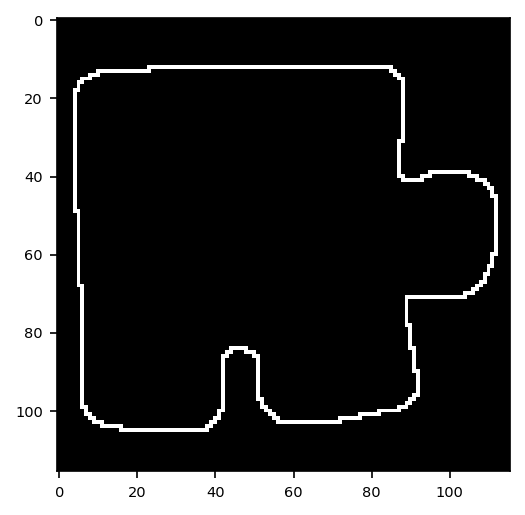

In [531]:
gray = cv2.cvtColor(black, cv2.COLOR_BGR2GRAY)
kernel = np.ones((3,3))
mask = cv2.erode(gray, kernel)
edges = gray - mask
plt.figure(dpi=150)
plt.imshow(edges, cmap='gray');

In [512]:
def rotate(image, degrees):
    if len(image.shape) == 3:
        rows,cols, _ = image.shape
    else:
        rows, cols = image.shape
        
    S = cv2.getRotationMatrix2D((cols/2,rows/2), degrees, 1)
    
    return cv2.warpAffine(image,S,(cols,rows)), S

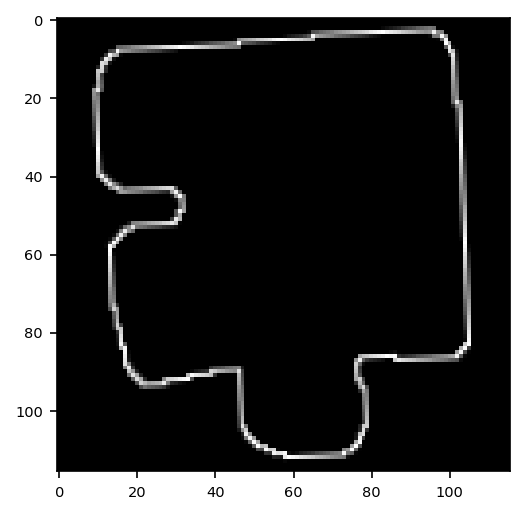

In [513]:


rotated, S = rotate(edges, rotation_angle)

plt.figure(dpi=150)
plt.imshow(rotated, cmap='gray');

In [514]:
corner_points = np.array(np.round([S.dot((point[0], point[1], 1)) for point in corner_points])).astype(np.int)

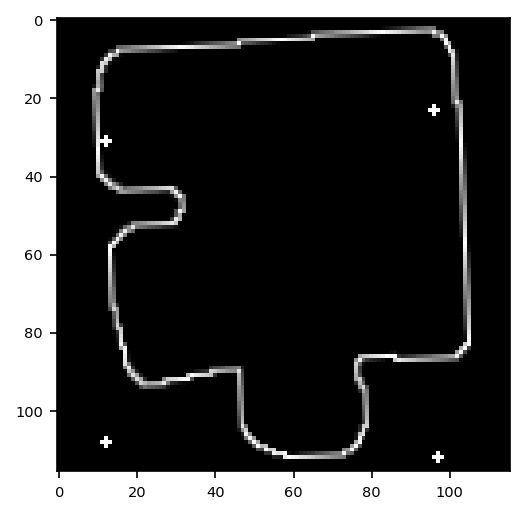

In [515]:
blackk = rotated.copy()
for point in corner_points:
    blackk[point[0]][point[1]]=255
    blackk[point[0]-1][point[1]]=255
    blackk[point[0]][point[1]-1]=255
    blackk[point[0]+1][point[1]]=255
    blackk[point[0]][point[1]+1]=255
plt.figure(dpi=150)
plt.imshow(blackk, cmap='gray');

тут нужно опять найти углы по ходу

In [525]:
idx_shape = np.where(gray == 0)
center = [int(np.round(coords.mean())) for coords in idx_shape]

In [532]:
def plot_img(img, cmap='gray', axis=False):
    plt.rcParams['font.size'] = 7
    plt.figure(figsize=(10,10))
    plt.imshow(img, cmap=cmap)
    if not axis:
        plt.axis('off')
    plt.grid()
    plt.show()

In [533]:
def corner_detection(edges, intersections, xb, yb, rect_size=10, show=False):

    # Find corners by taking the highest distant point from a 45 degrees inclined line
    # inside a squared ROI centerd on the previously found intersection point.
    # Inclination of the line depends on which corner we are looking for, and is
    # computed based on the position of the barycenter of the piece.

    corners = []

    for idx, intersection in enumerate(intersections):

        xi, yi = intersection

        m = -1 if (yb - yi)*(xb - xi) > 0 else 1
        y0 = 0 if yb < yi else 2*rect_size
        x0 = 0 if xb < xi else 2*rect_size

        a, b, c = m, -1, -m*x0 + y0

        rect = edges[yi - rect_size: yi + rect_size, xi - rect_size: xi + rect_size].copy()
        plot_img(rect)
        edge_idx = np.nonzero(rect)
        if len(edge_idx[0]) > 0:
            distances = [(a*edge_x + b*edge_y + c)**2 for edge_y, edge_x in zip(*edge_idx)]
            corner_idx = np.argmax(distances)

            rect_corner = np.array((edge_idx[1][corner_idx], edge_idx[0][corner_idx]))
            offset_corner = rect_corner - rect_size
            real_corner = intersection + offset_corner

            corners.append(real_corner)
        else:
            # If the window is completely black I can make no assumption: I keep the same corner
            corners.append(intersection)

        if show:
            plt.subplot(220 + idx + 1)
            cv2.circle(rect, tuple(rect_corner), 5, 128)

            plt.title("{0} | {1}".format(intersection, (x0, y0)))
            plt.imshow(rect)

    if show:
        plt.show()

    return corners

In [534]:
corners

[array([31, 12]), array([108,  12]), array([92, 96]), array([23, 96])]

In [535]:
corner_points

array([[ 31,  12],
       [108,  12],
       [112,  97],
       [ 23,  96]])

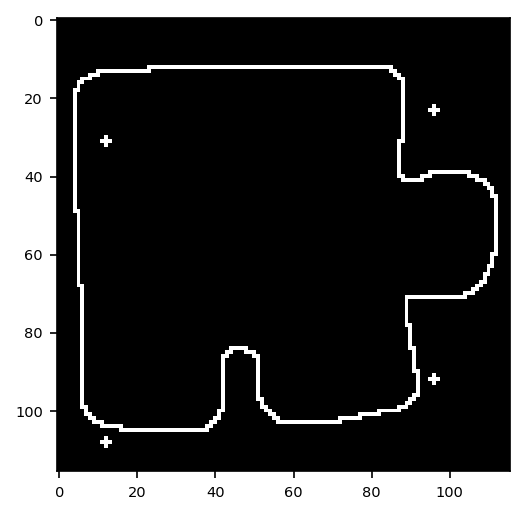

In [536]:
blackk = edges.copy()
for point in corners:
    blackk[point[0]][point[1]]=255
    blackk[point[0]-1][point[1]]=255
    blackk[point[0]][point[1]-1]=255
    blackk[point[0]+1][point[1]]=255
    blackk[point[0]][point[1]+1]=255
plt.figure(dpi=150)
plt.imshow(blackk, cmap='gray');